In [1]:
import numpy as np
import scipy.stats as sp
import math
import matplotlib.pyplot as plt

In [2]:
def brownian_motion(num_traject, num_steps, S0, T, mu=0, sigma=1, geometric=False):
    '''Produces standard, arithmetic, and geometric brownian motions'''  
    
    dt = T/num_steps
    
    if not geometric:
    
        #if arithmetic BM, set drift and volatility manually.Default state leads to standard BM.
        #produce a table standard normally distributed samples scaled by time

        samples = sp.norm.rvs(0, 1, size=(num_traject, num_steps))*math.sqrt(dt)*sigma

        #add the initial value to every trajectory (every row of the table)

        aug_samples = np.hstack([np.ones((num_traject, 1))*S0,samples]) + mu*dt

        #calculate the value of the brownian motion at every step for every trajectory

        bm = aug_samples.cumsum(axis=1)
     
    else:
            
        #use GBM solution formula to produce trajectories St=S0*exp((μ-σ^2/2)*t+σ*sqrt(t)*ε , ε~Ν(0,1)
        
        samples = np.exp((mu - sigma**2/2)*dt + sigma*math.sqrt(dt)*sp.norm.rvs(0, 1, size=(num_traject, num_steps)))
        
        aug_samples = np.hstack([np.ones((num_traject, 1))*S0,samples])
        
        bm = aug_samples.cumprod(axis=1)
            
    
    return bm
    

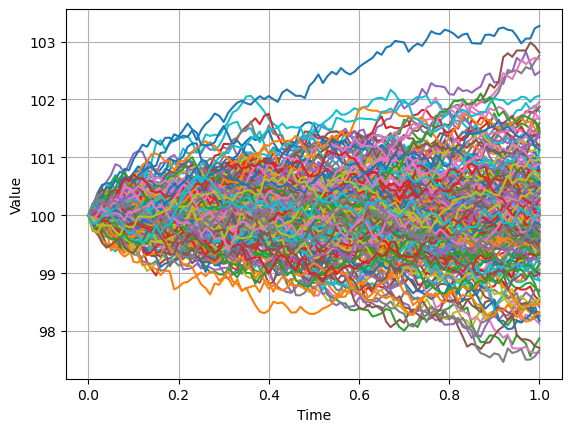

In [3]:
trajectories = 200
steps = 100
S0 = 100
time = 1  #in years


bm = brownian_motion(trajectories, steps, S0, time)

for k in range(trajectories):
    plt.plot(np.linspace(0, time, steps+1), bm[k])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

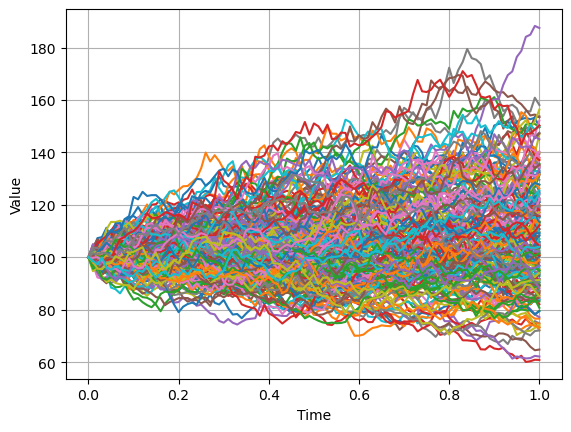

In [4]:
drift = 0.1
volatility = 0.2

gbm = brownian_motion(trajectories, steps, S0, time, drift, volatility, geometric=True)

for k in range(trajectories):
    plt.plot(np.linspace(0, time, steps+1), gbm[k])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)

In [5]:
def mc_options(trajectories, steps, S0, T, sigma, K, r):
    '''Monte carlo simulator for calls and puts    
       Due to risk neutral valuation r is used as mu in GBM'''
    
    St = brownian_motion(trajectories, steps, S0, T, r, sigma, geometric=True)
    
    call_payoff = np.maximum(St[:,-1] - K, 0)
    
    put_payoff = np.maximum(K - St[:,-1], 0)
    
    disc_call_payoff = np.exp(-r*T)*call_payoff
    
    disc_put_payoff = np.exp(-r*T)*put_payoff
        
    return disc_call_payoff.mean(), disc_put_payoff.mean()
    
    

In [6]:
class black_scholes:
    '''Black Scholes price and Greeks for calls and puts''' 

    def __init__(self, S0, T, sigma, K, r, dividend=0, option_type='Call'):
        
        self.S0 = S0
        
        self.T = T
        
        self.sigma = sigma
        
        self.K = K
        
        self. r= r
        
        self.q = dividend 
        
        self.d1 = (np.log(self.S0/self.K) + (self.r - self.q + self.sigma**2/2)*self.T) / (self.sigma*math.sqrt(self.T))
        
        self.d2 = self.d1 - self.sigma*math.sqrt(self.T)
        
        self.option_type = option_type
        
        
    def price(self):
        '''Calculates price for calls and puts'''
        
        if self.option_type=='Call':
        
            price= self.S0*np.exp(-self.q*self.T)*sp.norm.cdf(self.d1) - self.K*np.exp(-self.r*self.T)*sp.norm.cdf(self.d2)
        
        else:
            
            price= self.K*np.exp(-self.r*self.T)*sp.norm.cdf(-self.d2) - self.S0*np.exp(-self.q*self.T)*sp.norm.cdf(-self.d1)
        
        return price
    
    
    def delta(self):
        '''Calculates rate of change in value w.r.t change in the underlying price'''
        
        if self.option_type =='Call':
            
            delta = np.exp(-self.q*self.T)*sp.norm.cdf(self.d1)
            
        else:
            
            delta = -np.exp(-self.q*self.T)*sp.norm.cdf(-self.d1)
            
        return delta
    
    
    def gamma(self):
        '''Calculates rate of change in Delta w.r.t change in the underlying price'''
        
        gamma = np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)/(self.S0*self.sigma*np.sqrt(self.T))   #default nom pdf is (0,1)
        
        return gamma
    
    
    def theta(self):
        '''Calculates rate of change in value w.r.t. to time'''
        
        if self.option_type == 'Call':
            
            theta = -np.exp(-self.q*self.T)*self.S0*sp.norm.pdf(d1)*self.sigma/(2*np.sqrt(self.T)) - self.r*self.K*np.exp(-self.r*self.T)*sp.norm.cdf(self.d2) + self.q*self.S0*np.exp(-self.q*self.T)*sp.norm.cdf(d1)
                                       
        else:
            
            theta = -np.exp(-self.q*self.T)*self.S0*sp.norm.pdf(d1)*self.sigma/(2*np.sqrt(self.T)) + self.r*self.K*np.exp(-self.r*self.T)*sp.norm.cdf(-self.d2) - self.q*self.S0*np.exp(-self.q*self.T)*sp.norm.cdf(-d1)
    
    def vega(self):
        '''Calculates rate of change in value w.r.t volatility'''
        
        vega = self.S0*np.exp(-self.q*self.T)*np.sqrt(self.T)*sp.norm.pdf(self.d1)
        
        return vega
    
    
    def rho(self):
        '''Calculates rate of change in value w.r.t. interest rates'''
        
        if self.option_type =='Call':
            
            rho = self.K*self.T*np.exp(-self.r*self.T)*sp.norm.pdf(self.d2)
            
        else:
            
            rho = -self.K*self.T*np.exp(-self.r*self.T)*sp.norm.pdf(-self.d2)
     
    
    def epsilon(self):
        '''Calculates percentage change in value w.r.t. percentage change in underlying's dividend yield'''
        
        if self.option_type =='Call':
            
            epsilon = -self.S0*self.T*np.exp(-self.q*self.T)*sp.norm.cdf(d1)
            
        else:
            
            epsilon = self.S0*self.T*np.exp(-self.q*self.T)*sp.norm.cdf(-d1)
        
    
    def vanna(self):
        '''Calculates rate of change of Delta w.r.t. volatility'''
        
        vanna = -np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)*self.d2/self.sigma
        
        return vanna
    
    
    def charm(self):
        '''Calculates rate of change of Delta w.r.t to time'''
        
        if self.option_type =='Call':
            
            charm = self.q*np.exp(-self.q*self.T)*sp.norm.cdf(self.d1) - np.exp(-self.q*self.T)*sp.norm.pdf(self.d1) * (2*(self.r - self.q)*self.T - self.d2*self.sigma*np.sqrt(self.T))/(2*self.T*self.sigma*np.sqrt(self.T))
            
        else:
            
            charm = -self.q*np.exp(-self.q*self.T)*sp.norm.cdf(-self.d1) - np.exp(-self.q*self.T)*sp.norm.pdf(self.d1) * (2*(self.r - self.q)*self.T - self.d2*self.sigma*np.sqrt(self.T))/(2*self.T*self.sigma*np.sqrt(self.T))
            
        return charm
    
    
    def vomma(self):
        '''Calculates rate of change of Vega w.r.t volatility'''
            
        vomma = self.S0*np.exp(-self.q*self.T)*np.sqrt(self.T)*sp.norm.pdf(self.d1)*self.d1*self.d2/self.sigma
            
        return vomma
        
        
    def vera(self):
        '''Calculates rate of change of rho w.r.t volatility'''
        
        vera = -self.K*self.T*np.exp(-self.r*self.T)*sp.norm.pdf(self.d2)*self.d1/self.sigma
        
        return vera
    
    
    def veta(self):
        '''Calculates rate of change of vega w.r.t. time'''
        
        veta = -self.S0*np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)*np.sqrt(self.d1) * (self.q + (self.r - self.q)*self.d1/(self.sigma*np.sqrt(self.T)) - (1 + self.d1*self.d2)/(2*self.T))
        
        return veta
    
    
    def speed(self):
        '''Calculates rate of change of Gamma w.r.t. to change in the underlying price'''
        
        speed = -np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)/(self.S0**2 * self.sigma*np.sqrt(self.T))*(self.d1/(self.sigma*np.sqrt(self.T))+1)
        
        return speed
    
    
    def zomma(self):
        '''Calculates rate of change of Gamma w.r.t. volatility'''
        
        zomma = np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)*(self.d1*self.d2 - 1)/(self.S0*self.sigma**2 * np.sqrt(self.T))
        
        return zomma
    
    
    def color(self):
        '''Calculates rate of change of Gamma w.r.t. time'''
        
        color = -np.exp(-self.q*self.T)*sp.norm.pdf(self.d1)/(2*self.S0*self.T*self.sigma*np.sqrt(self.T))*(2*self.q*self.T + 1 + (2*(self.r - self.q)*self.T - self.d2*self.sigma*np.sqrt(self.T))/(self.sigma*np.sqrt(self.T)*self.d1) )
        
        return color
    
    
    def ultima(self):
        '''Calculates rate of change of vomma w.r.t. volatility'''
        
        ultima =  - self.vega/self.sigma**2 * (self.d1*self.d2*(1 - self.d1*self.d2) + self.d1**2 + self.d2**2)
    
        return ultima
    
        
        

        

In [7]:
call_mc , put_mc = mc_options(100000,1,95,1,0.25,100,0.04)
call_bs = black_scholes(95,1,0.25,100,0.04)
put_bs =black_scholes(95,1,0.25,100,0.04,option_type='put')
print(put_mc,put_bs.price())
print(call_mc,call_bs.price())

10.059461414922689 10.053044195540203
8.938934726326876 8.974100280307887


In [8]:
def binomial_tree(S0, K, r, T, sigma , N , option_type='call'):

    dT = float(T) / N                            
    u = np.exp(sigma * np.sqrt(dT))                 
    d = 1.0 / u                                   
    N=int(N)
    V = np.zeros(N+1)                             
    S_T = np.array( [(S0 * u**j * d**(N - j)) for j in range(N + 1)] )  

    a = np.exp(r * dT)    
    p = (a - d)/ (u - d)  # risk neutral up probability
    q = 1.0 - p           # risk neutral down probability   

    if option_type =="call":
        V[:] = np.maximum(S_T-K, 0.0)
    else:
        V[:] = np.maximum(K-S_T, 0.0)

    for i in range(N-1, -1, -1):
        V[:-1] = np.exp(-r*dT) * (p * V[1:] + q * V[:-1])    # the price vector is overwritten at each step
    return V[0]

In [9]:
r = 0.05
sig = 0.2
T = 1
N = 10000 
S0 = 100
K=110

tc = binomial_tree(S0,K,r,T,sig,N)
bs = black_scholes(S0,T,sig,K,r)

print(tc,bs.price())


6.0400726718574465 6.040088129724239


In [10]:
#Heston model path generation

N = 100             # time steps 
paths = 100               # number of paths
T = 1
T_vec, dt = np.linspace(0,T,N, retstep=True )


S0 = 100          # spot price
X0 = np.log(S0)   # log price
v0 = 0.04         # spot variance
Y0 = np.log(v0)   # log-variance 

r = 0.0                                           # drift
rho = -0.2                                         # correlation coefficient
kappa = 2                                          # mean reversion coefficient
theta = 0.04                                       # long-term variance
sigma = 0.3                                        # Vol of Vol - Volatility of instantaneous variance
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )   # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)                 # Feller condition

# Generate random Brownian Motion
MU = np.array([0, 0])
COV = np.matrix([[1, rho], [rho, 1]])
W = sp.multivariate_normal.rvs( mean=MU, cov=COV, size=(paths,N-1) ) #n-1 because we are going to set the first step ourselves
W_S = W[:,:,0]   # Stock Brownian motion:     W_1
W_v = W[:,:,1]   # Variance Brownian motion:  W_2

# Initialize vectors
Y = np.zeros((paths,N))
Y[:,0] = Y0
X = np.zeros((paths,N))
X[:,0] = X0
v = np.zeros(N)

# Generate paths
for t in range(0,N-1):
    v = np.exp(Y[:,t])    # variance 
    v_sq = np.sqrt(v)     # square root of variance 
    
    Y[:,t+1] = Y[:,t] + (1/v)*( kappa*(theta - v) - 0.5*sigma**2 )*dt + sigma * (1/v_sq) * np.sqrt(dt) * W_v[:,t]   
    X[:,t+1] = X[:,t] + (r - 0.5*v)*dt + v_sq * np.sqrt(dt) * W_S[:,t]

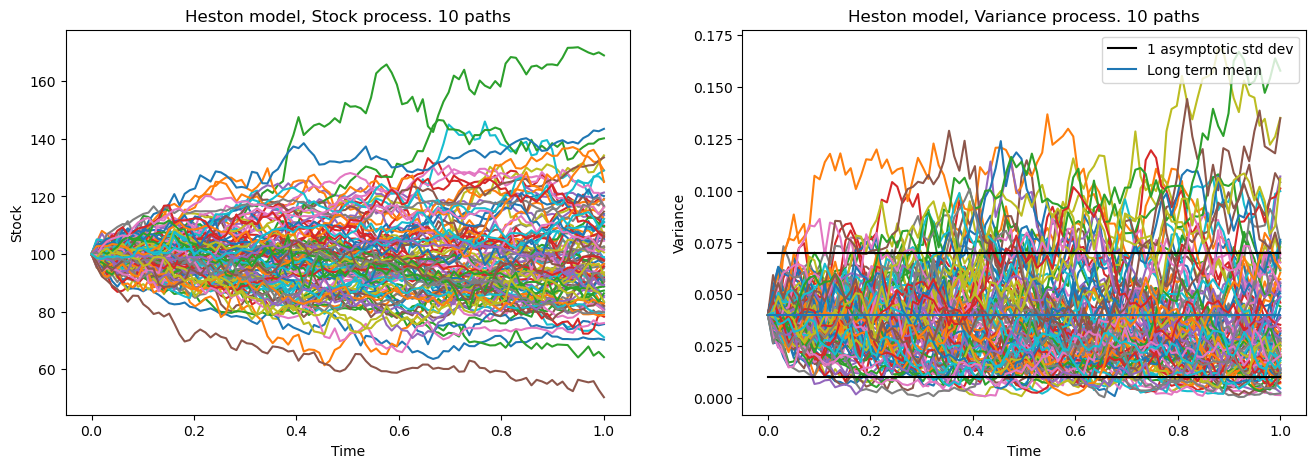

In [13]:
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(T_vec, np.exp(X.T) )
ax1.set_title("Heston model, Stock process. 10 paths"); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, np.exp(Y.T) )
ax2.set_title("Heston model, Variance process. 10 paths"); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); 
plt.show()